# Homework 4: Generalization and Regularization
---

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import random

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import one_hot
from torch.utils.data import random_split

c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
torch.manual_seed(0)
random.seed(4)

---
## Introduction to PyTorch and Autograd

In [3]:
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0, requires_grad = True)
z = x ** 2 + 2 * y ** 2

In [4]:
print(f"x.requires_grad: {x.requires_grad}")
print(f"y.requires_grad: {y.requires_grad}")
print(f"z.requires_grad: {z.requires_grad}")

x.requires_grad: True
y.requires_grad: True
z.requires_grad: True


In [5]:
z.backward()

In [6]:
print(f"Gradient of x: {x.grad}")
print(f"Gradient of y: {y.grad}")

Gradient of x: 2.0
Gradient of y: 8.0


In [7]:
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0, requires_grad = True)
z = x ** 2 + 2 * y ** 2
a = torch.sin(z)

In [8]:
print(f"a.requires_grad: {a.requires_grad}")
print(a.grad_fn)
print(a.grad_fn.next_functions)
print(z.grad_fn)
print(x.grad_fn)

a.requires_grad: True
((<AddBackward0 object at 0x00000228A2877820>, 0),)
None


In [9]:
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0, requires_grad = True)
z = x ** 2 + 2 * y ** 2
x_detached = x.detach()
z.backward()

In [10]:
print(f"x.requires_grad: {x.requires_grad}")
print(f"x_detached.requires_grad: {x_detached.requires_grad}")
print(f"x.grad: {x.grad}")
print(f"x_detached.grad: {x_detached.grad}")

x.requires_grad: True
x_detached.requires_grad: False
x.grad: 2.0
x_detached.grad: None


In [11]:
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0, requires_grad = True)
z = x ** 2 + 2 * y ** 2
x_clone = x.clone()
x_clone = torch.tensor(5.0)

In [12]:
print(f"x_clone: {x_clone}")
print(f"x: {x}")
print(f"x_clone.requires_grad: {x_clone.requires_grad}")

x_clone: 5.0
x: 1.0
x_clone.requires_grad: False


In [13]:
x_clone = x.clone().detach()

In [14]:
print(f"x_clone.requires_grad: {x_clone.requires_grad}")

x_clone.requires_grad: False


In [15]:
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0, requires_grad = True)
z = x ** 2 + 2 * y ** 2

with torch.no_grad():
    a = torch.sin(x)

In [16]:
print(f"a.requires_grad: {a.requires_grad}")

a.requires_grad: False


---
## Build a Neural Network and Train Using `autograd`

---
### Define `ShallowNet`

**Exercise 1 [10/10]**
1. The `ShallowNet` takes input size `n_x`, output size `n_y`, and width `n_h`.
2. Instead of manually specifying weights and biases, use `nn.Linear()` to define **linear transformations** to compute preactivation that include weights and biases internally.
3. Define the activation function `self.act` as a class attribute using `nn.ReLU()`.
4. Implement the `forward()` method to perform forward propagation and return the output of the network.

In [17]:
class ShallowNet(nn.Module):

    # Initialize the network with input size, hidden layer size, and output size
    def __init__(self, n_x, n_h, n_y):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(n_x, n_h)
        self.fc2 = nn.Linear(n_h, n_y)
        self.act = nn.ReLU()

    # Define the forward pass
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [18]:
n_x = 4
n_h = 10
n_y = 1
model = ShallowNet(n_x, n_h, n_y)

In [19]:
print(model)

ShallowNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (act): ReLU()
)


In [20]:
num_samples = 8
x = torch.randn(num_samples, n_x)
output = model(x)

In [21]:
print(output)

tensor([[ 0.3817],
        [ 0.3093],
        [ 0.2687],
        [ 0.1068],
        [-0.0068],
        [ 0.0091],
        [ 0.1560],
        [ 0.1721]], grad_fn=<AddmmBackward0>)


**Exercise 2 [10/10]**:
Define Loss Function and Optimizer
1. In each training loop, evaluate the `model` on the entire training set `x` to obtain the `output`.
2. Compute the `loss` by using the predefined loss function `criterion` and comparing the `output` with the ground truth labels `y`.
3. Use autograd to compute the gradients by calling `loss.backward()` instead of calling `model.backward()` like we did in the last assignment.
4. The computed gradients are automatically stored in the `model`’s parameters, which are passed into the `optimizer`. Apply a gradient descent update by calling `optimizer.step()` as done in the previous assignment.

In [22]:
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
x = torch.randn(num_samples, n_x)
y = torch.randn(num_samples, 1)
num_epochs = 10

In [23]:
for epoch in range(num_epochs):

    optimizer.zero_grad() # Zero the gradients
    output = model(x) # Forward pass
    loss = criterion(output, y) # Compute the loss
    loss.backward() # Compute the gradient of the loss
    optimizer.step() # # Update the model's parameters

    print(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {loss.item():.4f}")

Epoch [1 / 10], Loss: 0.9496
Epoch [2 / 10], Loss: 0.9107
Epoch [3 / 10], Loss: 0.8750
Epoch [4 / 10], Loss: 0.8421
Epoch [5 / 10], Loss: 0.8119
Epoch [6 / 10], Loss: 0.7841
Epoch [7 / 10], Loss: 0.7585
Epoch [8 / 10], Loss: 0.7350
Epoch [9 / 10], Loss: 0.7134
Epoch [10 / 10], Loss: 0.6935


---
### Use `DataLoader` for Mini-Batch SGD

**Exercise 3 [10/10]**
1. Generate random data `x` and `y` as before.
2. In PyTorch, use `TensorDataset(x, y)` to wrap the input tensor `x` and label tensor `y` into a dataset. Ensure that the first dimension (number of samples) matches for both tensors.
3. PyTorch’s `DataLoader` can automatically divide a dataset into mini-batches and shuffle the data after each epoch when `shuffle = True` is set.
4. Set the `batch_size = 64` and shuffle=True when creating the data_loader.

In [24]:
num_samples = 1000
n_x = 10
n_y = 1
x = torch.randn(num_samples, n_x)
y = torch.randn(num_samples, n_y)
dataset = TensorDataset(x, y)
batch_size = 32
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

**Exercise 4 [10/10]**:
Use SGD with mini-batches to train the `ShallowNet`.

1. Define a `ShallowNet` with a hidden layer width `n_h = 10`.
2. Specifiy the loss `criterion` using `MSELoss()`.
3. Define the SGD `optimizer` using `torch.optim.SGD`.
4. For each mini-batch, `data_loader` return a `(inputs, targets)` pair.
 - We evaluate our `model` on the `inputs` to get `outputs`
 - Then compute the `loss` using `outputs` and `targets`
 - Compute the gradients by calling `loss.backward()`
 - Employ the gradient update using `optimizer.step()`

In [25]:
n_h = 10
model = ShallowNet(n_x = n_x, n_h = n_h, n_y = n_y)
criterion = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
num_epochs = 10

In [26]:
for epoch in range(num_epochs):
    running_loss = 0.0 # Initialize running loss for each epoch

    for inputs, targets in data_loader:
        optimizer.zero_grad() # Zero the gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Compute the loss
        loss.backward() # Compute the gradient of the loss
        optimizer.step() # Update the model's parameters
        running_loss += loss.item() # Accumulate the loss
 
    avg_loss = running_loss / len(data_loader) # Compute the average loss
    
    print(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1 / 10], Loss: 1.0709
Epoch [2 / 10], Loss: 1.0582
Epoch [3 / 10], Loss: 1.0858
Epoch [4 / 10], Loss: 1.0414
Epoch [5 / 10], Loss: 1.0309
Epoch [6 / 10], Loss: 1.0312
Epoch [7 / 10], Loss: 1.0384
Epoch [8 / 10], Loss: 1.0431
Epoch [9 / 10], Loss: 1.0290
Epoch [10 / 10], Loss: 1.0196


---
### Train on a Realistic Dataset Using Pytorch

In [27]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.26MB/s]


In [28]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Input shape: {train_dataset[0][0].shape}")

Number of training samples: 60000
Number of test samples: 10000
Input shape: torch.Size([1, 28, 28])


In [29]:
def plot_images(dataset, num_images = 5):

    random_indices = torch.randperm(len(dataset))[:num_images] # Generate random indices to select images from the dataset
    fig, axes = plt.subplots(1, num_images, figsize = (12, 4))

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]

        if image.ndim == 3:
            image = image.permute(1, 2, 0)
        else:
            image = image.squeeze()

        axes[i].imshow(image, cmap = 'gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

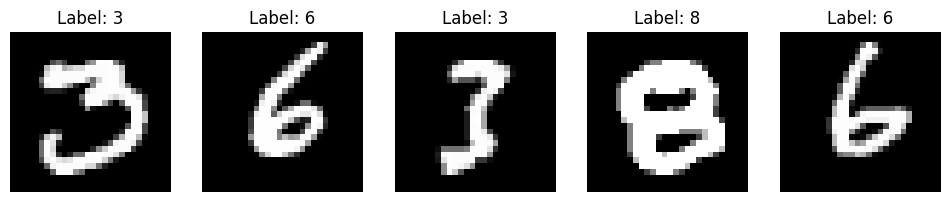

In [30]:
plot_images(train_dataset, num_images = 5)

**Exercise 5 [10/10]**: To apply SGD with mini-batch, we need `DataLoader` to load the data as mini-batches. Additionally, to moniter the performance not only during the training but also the test dataset (or validation dataset for tuning), we need both `train_loader` and `test_loader`.
1. Define `batch_size` with size value `64`.
2. Define `train_loader` using `DataLoader`, ensuring the `shuffle=True` flag is set to randomly shuffle the training data after each epoch.
3. Define `test_loader` using `DataLoader` for the test dataset, and since it’s not necessary to shuffle the test data, you can leave the shuffle flag as the default (False).

In [31]:
# Create a DataLoader for dataset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

**Exercise 6 [10/10]:**
1. Use `ShallowNet` to define a two-layer network `model` with `10` hidden units and `n_y=10` as MNIST contains `10` digits.
2. Specify the loss critarion to be `nn.MSELoss()`.
3. Define SGD optimizer using `torch.optim.SGD()` by passing the learning rate and the model's parameters.
4. For each epoch, we loop over each mini-batch `(inputs, targets)` loaded from `train_loader`:
  - Since each image in `inputs` has shape `28x28`, but the MLP treats input as a **vector**, reshape inputs using `.view(-1)` to flatten the images.
  - Compute the `outputs` by passing the `inputs` through the `model`
  - The model is designed for `10` output classes, but targets are integer values (class labels). Convert targets to **One-Hot Encoding** using `torch.nn.functional.one_hot(targets, num_classes=10)`.
  - Compute the `train_loss` using `critarion` on `outputs` and `targets`
  - Accumulate the `train_loss` into `train_running_loss`
  - Perform gradient computation and take the optimization step to update model's parameters.
  - Apply the same steps to `test_loader` to compute `test_loss` and update `test_running_loss`, excpet for skipping gradient computaiton and optimization steps
5. At end of each epoch, store the averaged `train_running_loss` and `test_running_loss` into `train_losses` and `test_losses`, respecitvely.

In [32]:
n_y = 10
model = ShallowNet(n_x = 28 * 28, n_h = 10, n_y = n_y)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
num_epochs = 10

In [33]:
# Initialize lists to store the training and testing losses
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    # Initialize running losses
    train_running_loss = 0.0
    test_running_loss = 0.0

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1) # Flatten the input images
            targets = torch.nn.functional.one_hot(targets, num_classes = 10).float() # Convert targets to one-hot encoding
            outputs = model(inputs) # Forward pass
            test_loss = criterion(outputs, targets) # Compute the test loss
            test_running_loss += test_loss.item() # Accumulate the test loss

    # Set the model back to training mode
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad() # Zero the gradients
        inputs = inputs.view(inputs.size(0), -1) # Flatten the input images
        targets = torch.nn.functional.one_hot(targets, num_classes = 10).float() # Convert targets to one-hot encoding
        outputs = model(inputs) # Forward pass
        train_loss = criterion(outputs, targets) # Compute the training loss
        train_running_loss += train_loss.item() # Accumulate the training loss
        train_loss.backward() # Backpropagate the gradients
        optimizer.step() # Update model parameters

    train_losses.append(train_running_loss / len(train_loader))
    test_losses.append(test_running_loss / len(test_loader))

    print(f"Epoch [{epoch + 1} / {num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1 / 10], Train Loss: 0.0781, Test Loss: 0.1495
Epoch [2 / 10], Train Loss: 0.0603, Test Loss: 0.0649
Epoch [3 / 10], Train Loss: 0.0538, Test Loss: 0.0559
Epoch [4 / 10], Train Loss: 0.0499, Test Loss: 0.0512
Epoch [5 / 10], Train Loss: 0.0472, Test Loss: 0.0481
Epoch [6 / 10], Train Loss: 0.0453, Test Loss: 0.0457
Epoch [7 / 10], Train Loss: 0.0439, Test Loss: 0.0441
Epoch [8 / 10], Train Loss: 0.0430, Test Loss: 0.0430
Epoch [9 / 10], Train Loss: 0.0423, Test Loss: 0.0422
Epoch [10 / 10], Train Loss: 0.0417, Test Loss: 0.0416


**Exercise 7 [10/10]:**
1. We need to import `matplotlib.pyplot` as `plt` as for ploting.
2. The function `plot_losses` takes `train_losses` and `test_losses` as input.
3. Use `plt.figure()` to define a figure with specified `figsize=(10,6)`.
4. Plot train_losses using `plt.plot()`. To distinguish it from `test_losses`, specify parameters such as `label`, `color`, and `linestyle`.
5. Plot `test_losses` as the `train_losses`.
6. Add labels and title.
7. Add legend.
8. Finish ploting, we `plt.show()` the plotted figure.

In [34]:
def plot_losses(train_losses, test_losses):

    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Training Loss', color = 'blue', linestyle = '--')
    plt.plot(test_losses, label = 'Testing Loss', color = 'red', linestyle = '-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()

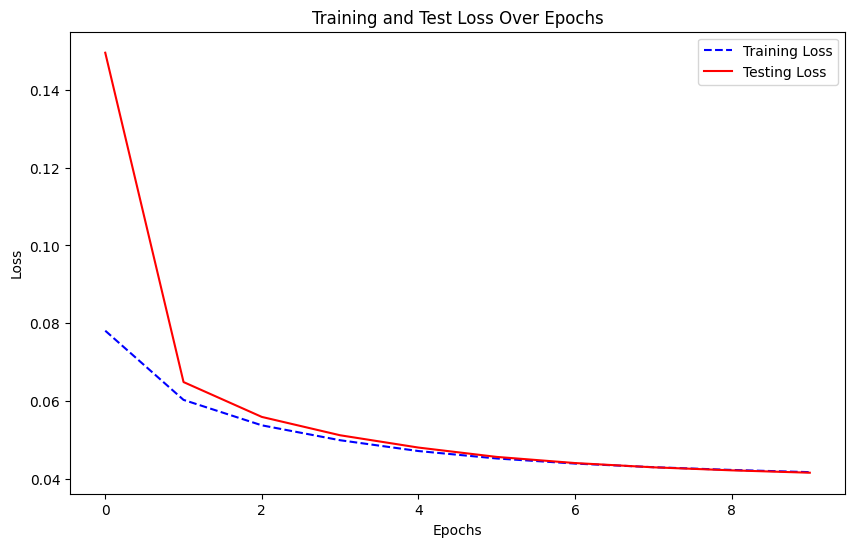

In [35]:
plot_losses(train_losses, test_losses)

**Exercise 8 [10/10]**:
1. The `predict_and_accuracy` takes a `model` and `data_loader`.
2. Loop over the `data_loader`, similar to how you handled the test loop:
 - For each mini-batch, compute the `outputs` by applying the `model` on `inputs`.
 - Use `torch.max(outputs.data, 1)` to retrieve the `predicted` class labels by finding the index of the maximum logit value in `outputs`.
 - We collect the `predicted` labels into the previous collection `predicitons` using `extend()` as to append a `list` to another `list` in Python.
 - Update the total number of predictions made (`total`) and the total number of correct predictions (`correct`).
3. After completing the loop, compute the `accuracy` as the ratio of correct predictions to the total number of predictions (`correct / total`).
4. Return total `predicitons` and `accuracy`.

In [36]:
def predict_and_accuracy(model, data_loader):

    # Set the model to evaluation mode
    model.eval()

    # Initialize counters
    correct = 0
    total = 0

    # List to store predictions
    predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.view(-1, 28 * 28) # Flatten the input images
            outputs = model(inputs) # Forward pass
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class
            predictions.extend(predicted.tolist()) # Store the predictions for later analysis
            total += targets.size(0) # Update the total sample count
            correct += (predicted == targets).sum().item() # Count the number of correct predictions

    # Calculate accuracy
    accuracy = correct / total

    return predictions, accuracy

In [37]:
_, train_accuracy = predict_and_accuracy(model, train_loader)
_, test_accuracy = predict_and_accuracy(model, test_loader)

In [38]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8468
Testing Accuracy: 0.8535


---
## Tuning Hyperparameters

---
### Train with Cross Entropy Loss

**Exercise 9 [10/10]**:
1. Define `model` as `ShallowNet` with `10` hidden units.
2. Specify the loss `criterion` as `nn.CrossEntropyLoss()`.
3. Set the `optimizer` to SGD (with mini-batches), using a learning rate of `0.01`.
4. Train the `mode`l for `10` epochs, recording the `train_losses` and `test_losses` at each epoch.
5. Plot the `train_losses` and `test_losses` to visualize the convergence behavior.
6. Make predictions on both the training and test datasets, and return their respective `accuracy`.

In [39]:
model = ShallowNet(n_x = 28 * 28, n_h = 8, n_y = n_y)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
num_epochs = 10

In [40]:
# Initialize lists to store the training and testing losses
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    # Initialize running losses
    train_running_loss = 0.0
    test_running_loss = 0.0

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, 28 * 28) # Flatten the images
            outputs = model(inputs) # Forward pass
            test_loss = criterion(outputs, targets) # Compute the test loss
            test_running_loss += test_loss.item() # Accumulate the test loss

    # Set the model back to training mode
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad() # Zero the gradients
        outputs = model(inputs) # Forward pass
        train_loss = criterion(outputs, targets) # Compute the training loss
        train_loss.backward() # Backpropagate the gradients
        optimizer.step() # Update model parameters
        train_running_loss += train_loss.item() # Accumulate the training loss

    train_losses.append(train_running_loss / len(train_loader))
    test_losses.append(test_running_loss / len(test_loader))
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/10], Train Loss: 1.0318, Test Loss: 2.3243
Epoch [2/10], Train Loss: 0.4533, Test Loss: 0.5011
Epoch [3/10], Train Loss: 0.3907, Test Loss: 0.3968
Epoch [4/10], Train Loss: 0.3636, Test Loss: 0.3599
Epoch [5/10], Train Loss: 0.3469, Test Loss: 0.3439
Epoch [6/10], Train Loss: 0.3340, Test Loss: 0.3345
Epoch [7/10], Train Loss: 0.3242, Test Loss: 0.3240
Epoch [8/10], Train Loss: 0.3161, Test Loss: 0.3190
Epoch [9/10], Train Loss: 0.3095, Test Loss: 0.3117
Epoch [10/10], Train Loss: 0.3035, Test Loss: 0.3081


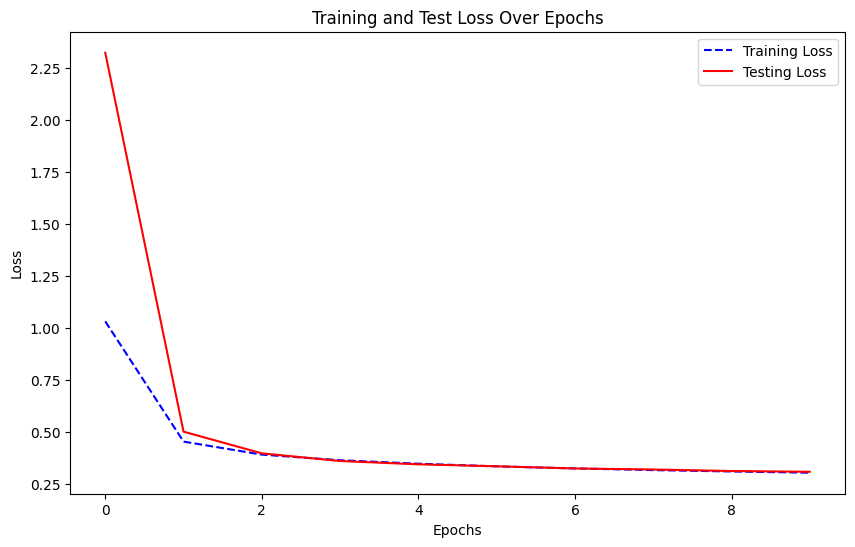

In [41]:
plot_losses(train_losses, test_losses)

In [42]:
_, train_accuracy = predict_and_accuracy(model, train_loader)
_, test_accuracy = predict_and_accuracy(model, test_loader)

In [43]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9169
Testing Accuracy: 0.9164


---
### Tune Network Width and Learning Rate

**Exercise 10 [10/10]**:
1. The first step is to split the `train_dataset` into `train_data` and `val_data`. Since the MNIST dataset is relatively straightforward, the results are not very sensitive to the choice of hyperparameters. Therefore, we can use a `90/10` split ratio by applying the `random_split(data, [size1, size2])` function.
2. Next, to simplify the coding process, we will write the training loop as a function `train_model()` that takes `model`, `train_loader`, loss `criterion`, `optimizer` and `num_epoches` as input.
3. In the third step, we need to define the search space. Create a range of values for both the learning rate and network width, ensuring that both are sampled using **log-scale**. Next, randomly sample `4` learning rates and widths from the defined search space to evaluate different combinations.
4. For each randomly selected combination of learning rate and width, train the model on the training set and validate it on the validation set. Track the performance (e.g., validation accuracy) for comparison.

In [44]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [45]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 54000
Number of validation samples: 6000


In [46]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)

In [47]:
def train_model(model, train_loader, criterion, optimizer, num_epochs = 10):

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad() # Zero the gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, targets) # Compute the loss
            loss.backward() # Backpropagate the loss to compute gradients
            optimizer.step() # Update the model parameters
            running_loss += loss.item() # Accumulate the loss

        print(f"Epoch [{epoch + 1} / {num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}")

In [48]:
learning_rates = torch.logspace(-3, 0, 5)
widths = [2, 16, 128, 1024]

In [49]:
print(f"Learning Rate: {learning_rates}")
print(f"Width: {widths}")

Learning Rate: tensor([0.0010, 0.0056, 0.0316, 0.1778, 1.0000])
Width: [2, 16, 128, 1024]


In [50]:
random_combinations = [(random.choice(learning_rates), random.choice(widths)) for _ in range(4)]

In [51]:
print(f"Random Combinations: {random_combinations}")

Random Combinations: [(tensor(0.0056), 128), (tensor(0.0010), 1024), (tensor(0.1778), 16), (tensor(0.0010), 2)]


In [52]:
best_params = None
best_val_accuracy = 0.0

In [53]:
for lr, width in random_combinations:

    print(f"Training with Learning Rate = {lr:.6f}, Width = {width}")

    model = ShallowNet(n_x = 28*28, n_h = width, n_y = n_y) # Initialize the model
    optimizer = torch.optim.SGD(model.parameters(), lr = lr) # Initialize the optimizer
    criterion = nn.CrossEntropyLoss() # Define the loss function

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs = 10)

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs) # Forward pass
            _, predicted = torch.max(outputs, 1) # Get the predicted class
            total += targets.size(0) # Update the total count
            correct += (predicted == targets).sum().item() # Update the number of correct predictions
    
    # Calculate validation accuracy
    val_accuracy = correct / total * 100

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = (lr, width)

print(f"Best parameters found: Learning Rate = {best_params[0]}, Width = {best_params[1]}")

Training with Learning Rate = 0.005623, Width = 128


Epoch [1 / 10], Train Loss: 1.7259
Epoch [2 / 10], Train Loss: 0.7805
Epoch [3 / 10], Train Loss: 0.5370
Epoch [4 / 10], Train Loss: 0.4506
Epoch [5 / 10], Train Loss: 0.4064
Epoch [6 / 10], Train Loss: 0.3790
Epoch [7 / 10], Train Loss: 0.3600
Epoch [8 / 10], Train Loss: 0.3454
Epoch [9 / 10], Train Loss: 0.3337
Epoch [10 / 10], Train Loss: 0.3238
Training with Learning Rate = 0.001000, Width = 1024
Epoch [1 / 10], Train Loss: 2.1710
Epoch [2 / 10], Train Loss: 1.8851
Epoch [3 / 10], Train Loss: 1.5694
Epoch [4 / 10], Train Loss: 1.2776
Epoch [5 / 10], Train Loss: 1.0545
Epoch [6 / 10], Train Loss: 0.8985
Epoch [7 / 10], Train Loss: 0.7896
Epoch [8 / 10], Train Loss: 0.7114
Epoch [9 / 10], Train Loss: 0.6530
Epoch [10 / 10], Train Loss: 0.6080
Training with Learning Rate = 0.177828, Width = 16
Epoch [1 / 10], Train Loss: 0.4273
Epoch [2 / 10], Train Loss: 0.2514
Epoch [3 / 10], Train Loss: 0.2131
Epoch [4 / 10], Train Loss: 0.1919
Epoch [5 / 10], Train Loss: 0.1786
Epoch [6 / 10], Tra

In [54]:
model = ShallowNet(n_x = 28 * 28, n_h = best_params[1], n_y = n_y)
optimizer = torch.optim.SGD(model.parameters(), lr = best_params[0])

In [55]:
train_model(model, train_loader, criterion, optimizer)

Epoch [1 / 10], Train Loss: 0.4224
Epoch [2 / 10], Train Loss: 0.2484
Epoch [3 / 10], Train Loss: 0.2114
Epoch [4 / 10], Train Loss: 0.1903
Epoch [5 / 10], Train Loss: 0.1774
Epoch [6 / 10], Train Loss: 0.1662
Epoch [7 / 10], Train Loss: 0.1587
Epoch [8 / 10], Train Loss: 0.1509
Epoch [9 / 10], Train Loss: 0.1456
Epoch [10 / 10], Train Loss: 0.1402


In [56]:
_, train_accuracy = predict_and_accuracy(model,train_loader)
_, val_accuracy = predict_and_accuracy(model,val_loader)
_, test_accuracy = predict_and_accuracy(model,test_loader)

In [57]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9623
Validation Accuracy: 0.9508
Testing Accuracy: 0.9514


---
## Overparameterizaiton

In [58]:
width = 2048
model = ShallowNet(n_x = 28 * 28, n_h = width, n_y = 10)
learning_rate = 1.0
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [59]:
print(f"Training with Learning Rate = {learning_rate}, Width = {width}")
train_model(model, train_loader, criterion, optimizer, num_epochs = 10)

Training with Learning Rate = 1.0, Width = 2048


Epoch [1 / 10], Train Loss: 0.2435
Epoch [2 / 10], Train Loss: 0.0850
Epoch [3 / 10], Train Loss: 0.0530
Epoch [4 / 10], Train Loss: 0.0359
Epoch [5 / 10], Train Loss: 0.0230
Epoch [6 / 10], Train Loss: 0.0146
Epoch [7 / 10], Train Loss: 0.0100
Epoch [8 / 10], Train Loss: 0.0054
Epoch [9 / 10], Train Loss: 0.0025
Epoch [10 / 10], Train Loss: 0.0014


In [60]:
_, train_accuracy = predict_and_accuracy(model,train_loader)
_, val_accuracy = predict_and_accuracy(model,val_loader)
_, test_accuracy = predict_and_accuracy(model,test_loader)

In [61]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Validation Accuracy: 0.9830
Testing Accuracy: 0.9853
